# Logistic Regression

In statistics, the logistic model (or logit model) is a widely used statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model (a form of binary regression). Mathematically, a binary logistic model has a dependent variable with two possible values, such as pass/fail, win/lose, alive/dead or healthy/sick; these are represented by an indicator variable, where the two values are labeled "0" and "1". In the logistic model, the log-odds (the logarithm of the odds) for the value labeled "1" is a linear combination of one or more independent variables ("predictors"); the independent variables can each be a binary variable (two classes, coded by an indicator variable) or a continuous variable (any real value). The corresponding probability of the value labeled "1" can vary between 0 (certainly the value "0") and 1 (certainly the value "1"), hence the labeling; the function that converts log-odds to probability is the logistic function, hence the name. The unit of measurement for the log-odds scale is called a logit, from logistic unit, hence the alternative names. Analogous models with a different sigmoid function instead of the logistic function can also be used, such as the probit model; the defining characteristic of the logistic model is that increasing one of the independent variables multiplicatively scales the odds of the given outcome at a constant rate, with each dependent variable having its own parameter; for a binary independent variable this generalizes the odds ratio. 

#### Creating the toy dataset

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

N = 2000

x_zeros = np.random.multivariate_normal(
                            mean = np.array((-1,0)), cov = 0.1*np.eye(2), size = (N,))

y_zeros = np.zeros((N,))

x_ones = np.random.multivariate_normal(
                            mean = np.array((0.7,0)), cov = 0.1*np.eye(2), size = (N,))

y_ones = np.ones((N,))


x_np = np.vstack([x_zeros,x_ones])

y_np = np.concatenate([y_zeros,y_ones])

An important thing to remember when implementing a machine learning algorithm is the generalization of the solution. We want that the solution can solve the most generic problem. That's why is important to ensure that the algorithm can generalize the solution on a new dataset, called <b>validation dataset</b>. This dataset dataset provides an unbiased evaluation of a model fit on the training dataset while tuning the model's hyperparameters(e.g. the number of hidden units in a neural network). Validation datasets can be used for regularization by early stopping: stop training when the error on the validation dataset increases, as this is a sign of overfitting to the training dataset. For this purpose sklearn provides a very useful method: <code>train_test_split</code>. A standard choice is to keep 1/3 of the entire dataset for validation purposes. 

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_np, y_np, test_size=0.3)

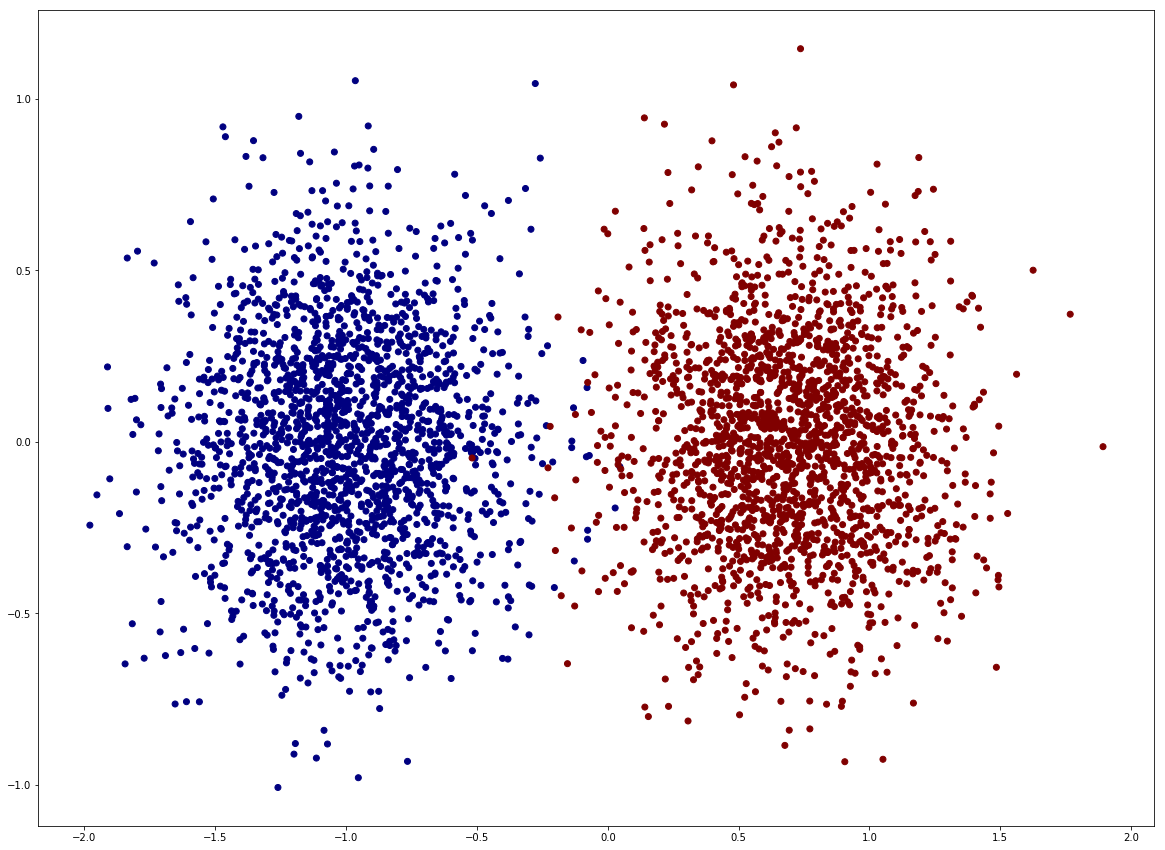

In [3]:
fig = plt.figure(figsize = (20,15))
plt.scatter(x_np[:,0],x_np[:,1], c = y_np, cmap = "jet")



### Model creation

In [4]:
tf.reset_default_graph()

with tf.name_scope("placeholders"):
    
    x = tf.placeholder(tf.float32, (None,2))
    y = tf.placeholder(tf.float32, (None,))
    
with tf.name_scope("weights"):
    
    W = tf.Variable(tf.random_normal((2,1)))
    b = tf.Variable(tf.random_normal((1,)))
    
with tf.name_scope("prediction"):
    
    y_logit = tf.squeeze(tf.matmul(x,W) + b) #Squeeze one dimension
    
    y_one_prob = tf.sigmoid(y_logit)
    
    y_pred = tf.round(y_one_prob)
    
with tf.name_scope("loss"):
    
    entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits = y_logit, labels = y)
    
    l = tf.reduce_sum(entropy)
    
with tf.name_scope("optim"):
    
    train_op = tf.train.AdamOptimizer(.01).minimize(l)
    
    train_writer = tf.summary.FileWriter('./Output/logistic-train', tf.get_default_graph())
    
with tf.name_scope("summaries"):
    
    tf.summary.scalar("loss",l)
    merged = tf.summary.merge_all()

W1212 13:26:38.295622 140208203347776 deprecation.py:323] From /home/wahid/Programs/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
n_steps = 5000

from tqdm import tqdm_notebook
pbar = tqdm_notebook(range(n_steps), desc = "Epochs")

from sklearn.metrics import accuracy_score
from scipy.special import logit

loss_val = []

loss_test = []
with tf.Session() as sess_log:
    
    sess_log.run(tf.global_variables_initializer())
    
    for i in range(n_steps):
        
        dicti = {x: X_train, y: Y_train}
        
        dict_test = {x: X_test, y: Y_test}
        
        _,summary,loss = sess_log.run([train_op,merged,l], feed_dict = dicti)
        
        if(i % 20):
            
            summary_t,loss_t = sess_log.run([merged,l], feed_dict = dict_test)
            
            loss_test.append(loss_t)
            
        loss_val.append(loss)
        
        
        train_writer.add_summary(summary,i)
        
        pbar.update()
        
    
    w_final, b_final = sess_log.run([W, b])

    # Make Predictions
    y_pred_np = sess_log.run(y_pred, feed_dict={x: x_np})
    
    pbar.close()
    

    score = accuracy_score(y_np, y_pred_np)
    print("Classification Accuracy: %f" % score)

sess_log.close()





Classification Accuracy: 0.995250


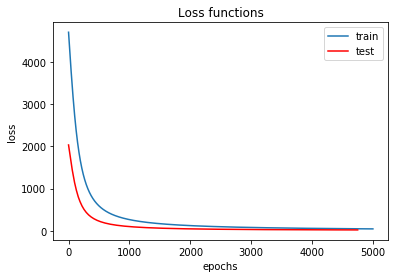

In [6]:
plt.plot(loss_val, label = 'train')
plt.plot(loss_test, color = 'red',  label = 'test')
plt.title("Loss functions")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

<Figure size 432x288 with 0 Axes>

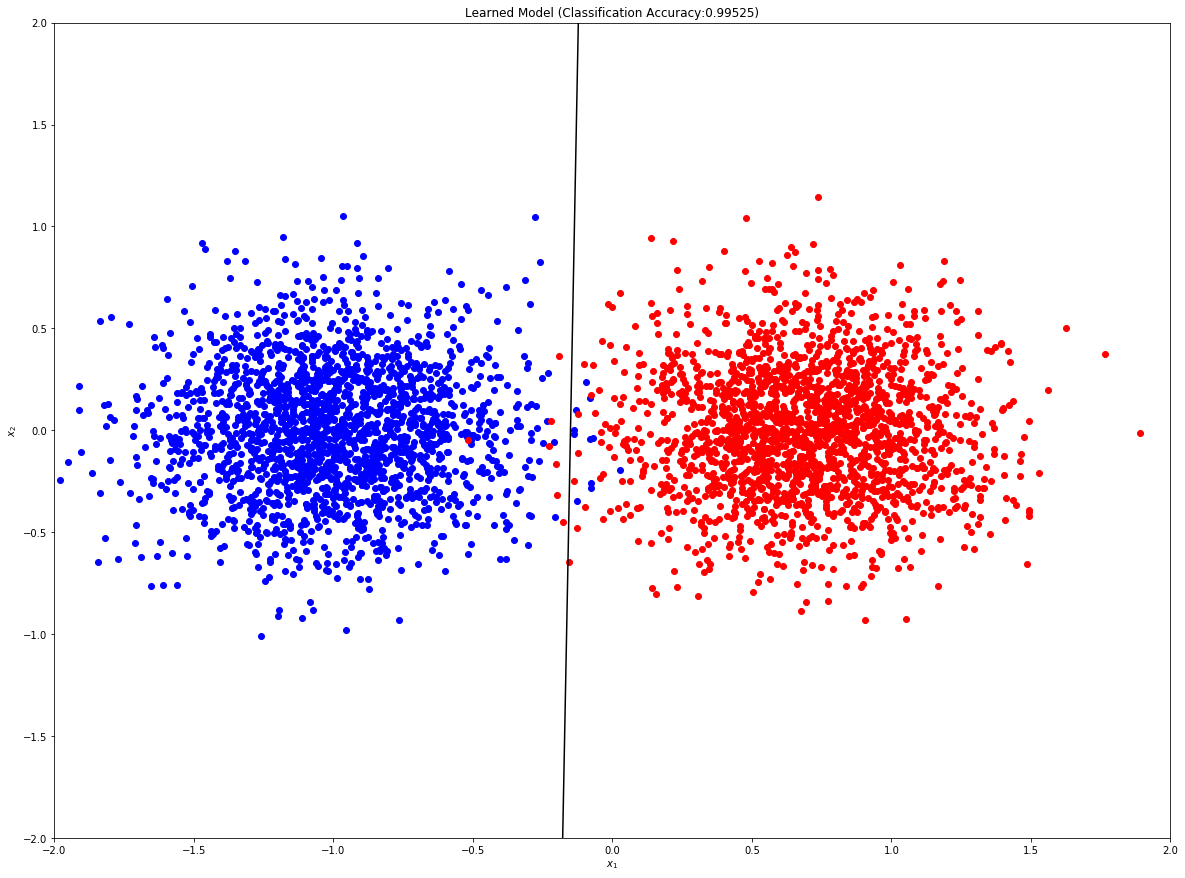

In [7]:
plt.clf()
# Save image of the data distribution
fig = plt.figure(figsize = (20,15))
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Learned Model (Classification Accuracy:{})".format(score))
plt.xlim(-2, 2)
plt.ylim(-2, 2)

# Plot Zeros
plt.scatter(x_zeros[:, 0], x_zeros[:, 1], color="blue")
plt.scatter(x_ones[:, 0], x_ones[:, 1], color="red")

x_left = -2
y_left = (1./w_final[1]) * (-b_final + logit(.5) - w_final[0]*x_left)

x_right = 2
y_right = (1./w_final[1]) * (-b_final + logit(.5) - w_final[0]*x_right)
plt.plot([x_left, x_right], [y_left, y_right], color='k')


In [8]:
#!tensorboard --logdir=./Output/logistic-train

<a id='Graph'></a>
<h1><center>Graph</center></h1>
<hr width = '50%'><br>
<img src ='./images/logic_reg.png'>

# Dataset generation and plot


In [9]:
# Generate a dataset and plot it
import sklearn.datasets
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import accuracy_score
from scipy.special import logit

from sklearn.preprocessing import StandardScaler

print("Tensorflow version:",(tf.__version__))
#np.random.seed(0)
X_d, y = sklearn.datasets.make_moons(10000, noise=0.1)

sc = StandardScaler()

X = sc.fit_transform(X_d)



Tensorflow version: 1.15.0


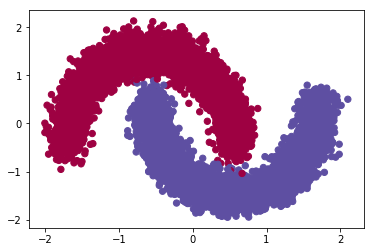

In [10]:
plt.scatter(X[:,0], X[:,1], s=40, c=y.reshape(-1,), cmap=plt.cm.Spectral)

In [11]:

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)

In [12]:
print("X_train shape: {} \nY_train shape: {} ".format(X_train.shape, Y_train.shape))


X_train shape: (7000, 2) 
Y_train shape: (7000,) 


In [13]:
n_hidden = 70
n_lay = 2

tf.reset_default_graph() #In order to permit us to instantiate new variables
    #d = len(X_train)

with tf.name_scope("placeholders"):

    x = tf.placeholder(tf.float32, (None,2))

    y = tf.placeholder(tf.float32, (None,))


with tf.name_scope("hidden-layer"):


    
    for lay in range(0,n_lay):
        
        if(lay == 0):
            
            W = tf.Variable(tf.random_normal((2,n_hidden)))

            b = tf.Variable(tf.random_normal((n_hidden,)))

            out_hidd = tf.nn.relu(tf.matmul(x,W) + b) #(600)

            W = tf.Variable(tf.random_normal((n_hidden,n_hidden)))

            b = tf.Variable(tf.random_normal((n_hidden,)))            
            
        
        out_hidd = tf.nn.relu(tf.matmul(out_hidd,W) + b)      
        


with tf.name_scope("output"):

    W = tf.Variable(tf.random_normal((n_hidden,1)))

    b = tf.Variable(tf.random_normal((1,)))

    y_logit = tf.matmul(out_hidd,W)+b

    y_one_prob = tf.sigmoid(y_logit)

    y_pred = tf.round(y_one_prob)

with tf.name_scope("loss"):

    y_expand = tf.expand_dims(y,1)

    entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits = y_logit, labels = y_expand)

    l = tf.reduce_sum(entropy)

with tf.name_scope("optim"):

    train_op = tf.train.AdamOptimizer(0.001).minimize(l)

with tf.name_scope("summaries"):

    tf.summary.scalar("loss",l)

    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter('./Output/nn-train', tf.get_default_graph())






In [14]:
from tqdm import tqdm_notebook

    
import imageio
images = []


loss_train = []
loss_test = []

acc_train = []
acc_test = [] 

n_steps = 200

pbar = tqdm_notebook(range(n_steps), desc = "Epochs")


with tf.Session() as fcnn:
    
    fcnn.run(tf.global_variables_initializer())
    
    for i in range(0,n_steps):          

        dicti_train = {x: X_train, y:Y_train} #Train dict

        _,summary,loss = fcnn.run([train_op,merged,l], feed_dict = dicti_train) #Running the train
        
        dicti_test = {x: X_test, y: Y_test} #Test dict
        summary_t, loss_t = fcnn.run([merged,l], feed_dict=dicti_test) #Running the test     
        
        #Loss functions
        loss_train.append(loss)
        loss_test.append(loss_t)
        train_writer.add_summary(summary,i)       
        
        #Making predictions    
        y_pred_train = fcnn.run(y_pred, feed_dict={x: X_train})
        score_train = accuracy_score(Y_train, y_pred_train) #Computing the accuracy   

        pbar.update()


        #if(i % 10 == 0): #One can decide not to test every epoch but after a few ones. (Rembember to indent)
        
        #Making predictions on the test dataset in order to compute the accuracy every step.
        y_pred_test = fcnn.run(y_pred, feed_dict={x: X_test}) 
        score_test = accuracy_score(Y_test, y_pred_test) #Computing the accuracy on the test dataset

        acc_train.append(score_train) 
        acc_test.append(score_test)

    w_final, b_final = fcnn.run([W, b]) #Saving the final results
    
    # Make Predictions on test
    y_pred_test = fcnn.run(y_pred, feed_dict={x: X_test}) #Final predictions
    
    y_proba = fcnn.run(y_one_prob, feed_dict = {x:X_test}) #Final predictions (probability)
    

    
    score = accuracy_score(Y_test, y_pred_test)
    print("Classification Accuracy: %f" % score)
fcnn.close() #Closing the session.



Classification Accuracy: 0.994000


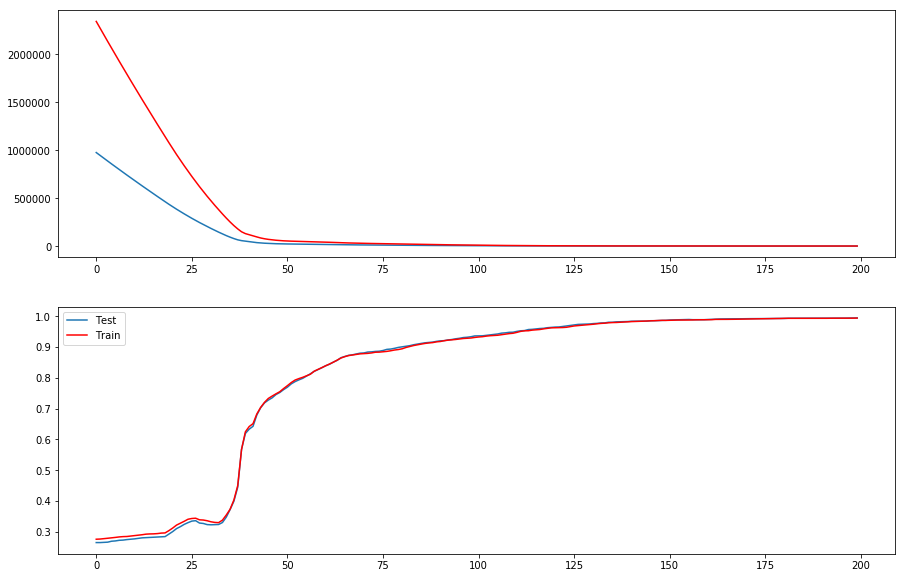

In [15]:
fig = plt.figure(figsize = (15,10))

plt.subplot(211)

plt.plot(loss_test, label = 'Test')
plt.plot(loss_train, color = 'red', label = 'Train' )

plt.subplot(212)

plt.plot(acc_test, label = 'Test')
plt.plot(acc_train, color = 'red', label = 'Train')

plt.legend()
plt.show()

## Confusion matrix

A useful explanation of the confusion matrix can be found here: <a href="https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62"> Confusion Matrix </a>

In [16]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize = (15,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0.99536117 0.00463883]
 [0.0073776  0.9926224 ]]


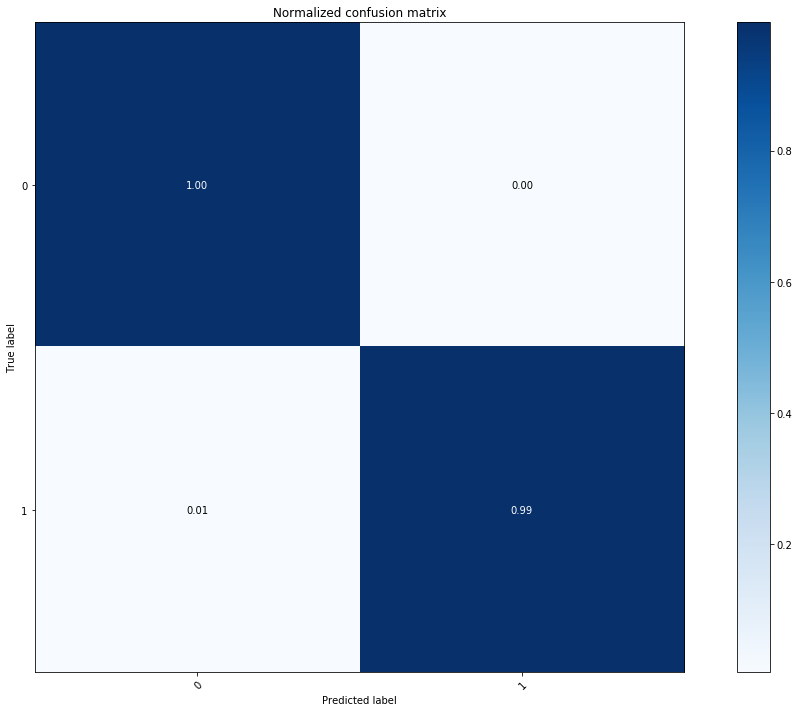

In [17]:
y_pred = y_pred_test.reshape(-1)
y_pred = y_pred.astype(int)
plot_confusion_matrix(Y_test,y_pred,classes = [0,1],normalize=True)

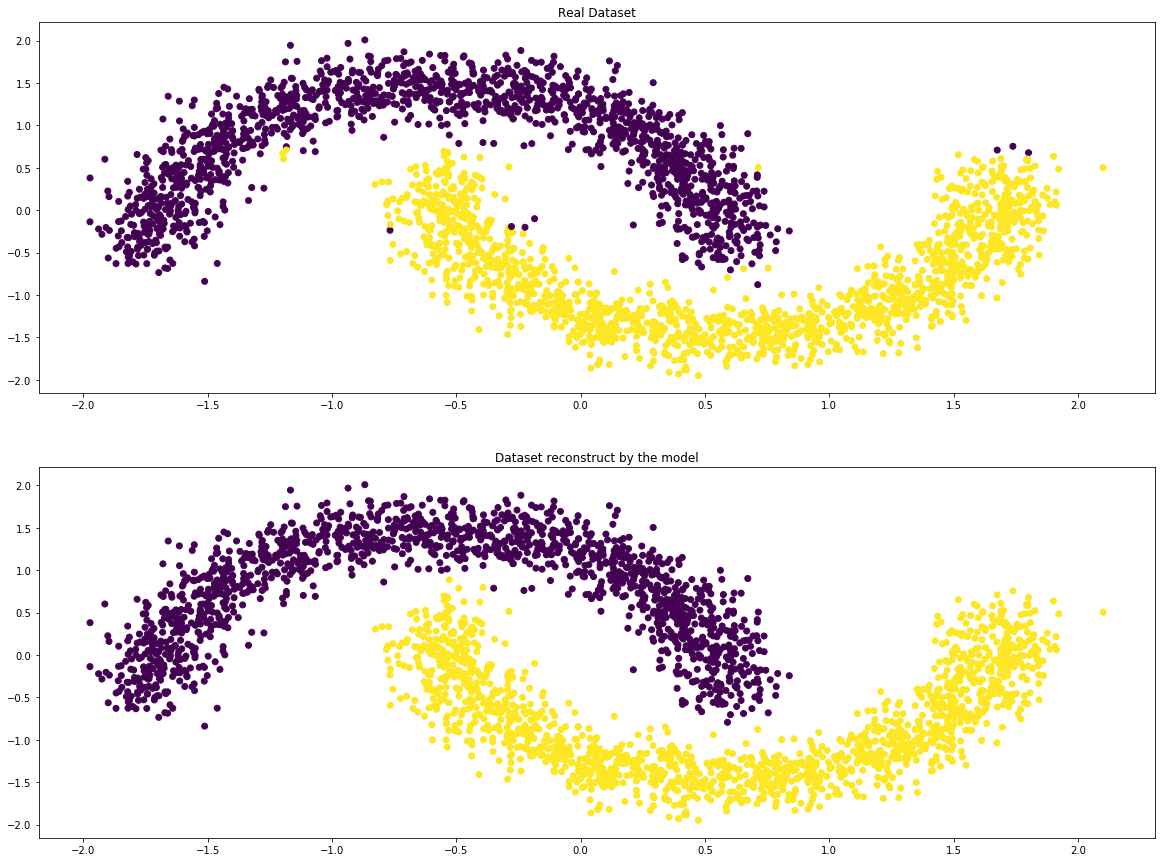

In [18]:
fig = plt.figure(figsize = (20,15))

ax1 = plt.subplot(211)

plt.scatter(X_test[:,0], X_test[:,1], c = y_pred_test.reshape(-1))

ax2 = plt.subplot(212)

plt.scatter(X_test[:,0],X_test[:,1], c = Y_test) 
ax1.title.set_text('Real Dataset')
ax2.title.set_text('Dataset reconstruct by the model')


In [19]:
#!tensorboard --logdir=./Output/nn-train

TensorBoard 1.15.0 at http://T470-wa:6006/ (Press CTRL+C to quit)
^C


<a id='Graph'></a>
<h1><center>Graph</center></h1>
<hr width = '50%'><br>
<img src ='./images/MLP.png'>